<a href="https://colab.research.google.com/github/andwan55/resdetection/blob/main/ResDecModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Set runtime to GPU for better performance.

In [2]:
! pip install kaggle --upgrade

In [3]:
! mkdir ~/.kaggle/

Go to "account" after clicking your icon on the Kaggle site. Download a new API token, and upload it into this notebook.

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 /root/.kaggle/kaggle.json

On the dataset page, click the three dots on the right and click "Copy API command". Add an exclamation mark and then paste it here.


In [6]:
! kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

 99% 1.73G/1.74G [00:41<00:00, 61.2MB/s]
100% 1.74G/1.74G [00:41<00:00, 45.0MB/s]


In [7]:
! mkdir dataset

Unzip the zip file dataset.

In [8]:
! unzip chest-xray-pneumoniacovid19tuberculosis.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/NORMAL/NORMAL2-IM-0843-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0845-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0846-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0847-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0848-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0849-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0851-0001-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0851-0001-0002.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0851-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0852-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0853-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0854-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0855-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0856-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0857-0001.jpeg  
  inflati

Check the testing folder for the image categories.

In [9]:
! ls dataset/test

COVID19  NORMAL  PNEUMONIA  TURBERCULOSIS


In [10]:
! ls dataset/test/TURBERCULOSIS

Tuberculosis-660.png  Tuberculosis-674.png  Tuberculosis-688.png
Tuberculosis-661.png  Tuberculosis-675.png  Tuberculosis-689.png
Tuberculosis-662.png  Tuberculosis-676.png  Tuberculosis-690.png
Tuberculosis-663.png  Tuberculosis-677.png  Tuberculosis-691.png
Tuberculosis-664.png  Tuberculosis-678.png  Tuberculosis-692.png
Tuberculosis-665.png  Tuberculosis-679.png  Tuberculosis-693.png
Tuberculosis-666.png  Tuberculosis-680.png  Tuberculosis-694.png
Tuberculosis-667.png  Tuberculosis-681.png  Tuberculosis-695.png
Tuberculosis-668.png  Tuberculosis-682.png  Tuberculosis-696.png
Tuberculosis-669.png  Tuberculosis-683.png  Tuberculosis-697.png
Tuberculosis-670.png  Tuberculosis-684.png  Tuberculosis-698.png
Tuberculosis-671.png  Tuberculosis-685.png  Tuberculosis-699.png
Tuberculosis-672.png  Tuberculosis-686.png  Tuberculosis-700.png
Tuberculosis-673.png  Tuberculosis-687.png


# Visual Display

Import relevant libraries to display dataset images.

In [11]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2 as cv
import os
import PIL

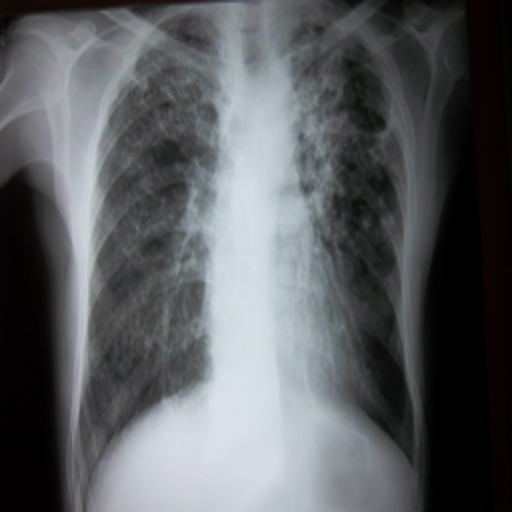

In [12]:
I = np.asarray(PIL.Image.open("dataset/test/TURBERCULOSIS/Tuberculosis-700.png"))
im = PIL.Image.fromarray(np.uint8(I))
im


In [13]:
I.shape

(512, 512, 3)

In [14]:
image_size = (150, 150)
img_height = 150
img_width = 150
batch_size = 32

Import images into Keras, which allows us to differentiate between training and testing data.

In [15]:
import tensorflow as tf 
from tensorflow import keras

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train/",
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/test/",
    image_size=image_size,
    batch_size=batch_size,
)

Found 6326 files belonging to 4 classes.
Found 771 files belonging to 4 classes.


In [16]:
im_classes = {
  0 : 'COVID19',
  1 : 'NORMAL',
  2 : 'PNEUMONIA',
  3 : 'TUBERCULOSIS',
}
class_labels = list(im_classes.values())
num_classes = len(class_labels)

# Data Analysis

First let's look at the composition of the training dataset.

In [17]:
import os 

images_per_class_training = {}
for folder in os.listdir("dataset/train"):
  images_per_class_training[folder] = len(os.listdir(f'dataset/train/{folder}'))
print(images_per_class_training)

{'COVID19': 460, 'NORMAL': 1341, 'TURBERCULOSIS': 650, 'PNEUMONIA': 3875}


In [18]:
dataset_size = sum(images_per_class_training.values())

for key, index in images_per_class_training.items():
  images_per_class_training[key] = round(images_per_class_training[key] / dataset_size,3)

print(images_per_class_training)

{'COVID19': 0.073, 'NORMAL': 0.212, 'TURBERCULOSIS': 0.103, 'PNEUMONIA': 0.613}


We see that we have a significantly higher number of pneumonia scanes than the other three categories.

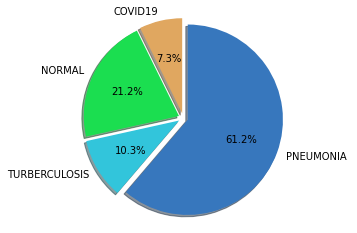

In [19]:
labels = images_per_class_training.keys()
sizes = images_per_class_training.values()
explode = (0.05, 0.05, 0.05, 0.05) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=['#e0a760','#1bde50','#32c5db','#3777bd'], 
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

As nearly two-thirds of the data is for pneumonia, in the future for the program we would want to have a more even distribution between the categories.
Let's move on to the testing dataset.

In [20]:
images_per_class_testing = {}
for folder in os.listdir("dataset/test"):
  images_per_class_testing[folder] = len(os.listdir(f'dataset/test/{folder}'))

print(images_per_class_testing)

{'COVID19': 106, 'NORMAL': 234, 'TURBERCULOSIS': 41, 'PNEUMONIA': 390}


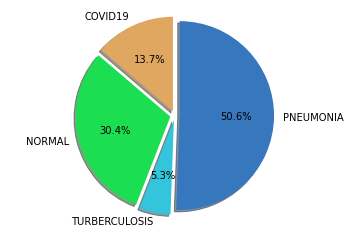

In [21]:
labels = images_per_class_testing.keys()
sizes = images_per_class_testing.values()
explode = (0.05, 0.05, 0.05, 0.05) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=['#e0a760','#1bde50','#32c5db','#3777bd'], 
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

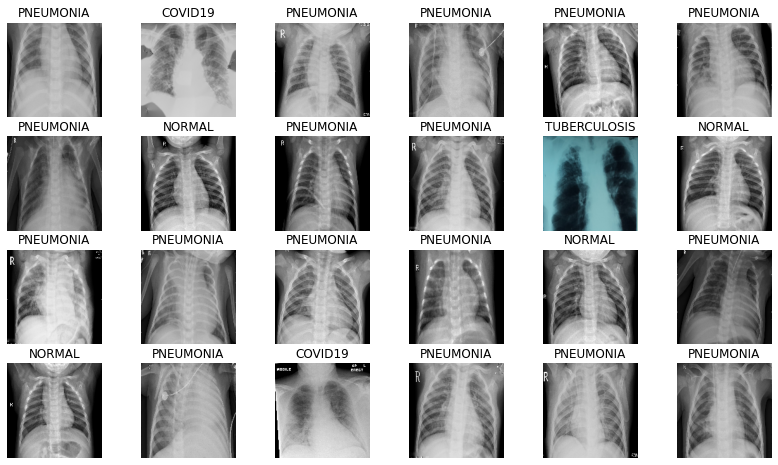

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for images, labels in train_ds.take(1):
    
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(im_classes[int(labels[i])])
        plt.axis("off")

# Building the Model

Begin training and building the model for image identification.

In [23]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [24]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

Start training the model here:

In [27]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/10
198/198 [==============================] - 59s 240ms/step - loss: 0.3817 - accuracy: 0.8595 - val_loss: 0.7749 - val_accuracy: 0.7497
Epoch 2/10
198/198 [==============================] - 49s 240ms/step - loss: 0.1287 - accuracy: 0.9554 - val_loss: 0.9497 - val_accuracy: 0.7834
Epoch 3/10
198/198 [==============================] - 48s 236ms/step - loss: 0.1079 - accuracy: 0.9646 - val_loss: 1.0667 - val_accuracy: 0.7601
Epoch 4/10
198/198 [==============================] - 48s 236ms/step - loss: 0.0757 - accuracy: 0.9715 - val_loss: 1.1163 - val_accuracy: 0.7834
Epoch 5/10
198/198 [==============================] - 48s 237ms/step - loss: 0.0556 - accuracy: 0.9821 - val_loss: 1.2359 - val_accuracy: 0.7938
Epoch 6/10
198/198 [==============================] - 49s 238ms/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 1.2016 - val_accuracy: 0.7925
Epoch 7/10
198/198 [==============================] - 48s 233ms/step - loss: 0.0565 - accuracy: 0.9794 - val_loss: 1.3862 - val_ac

We see that our average accuracy is 96.78% for training (images the model has seen), and an average accuracy of 77.36% for testing (images that have not been seen before).

Now we should see which category is reducing accuracy and why.

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

def get_preds_and_trues(model_used, ds):
  trues = []
  preds = []
  for input, labels in ds:
    batch_predictions = model_used.predict(x=input)
    for pred in batch_predictions:
      preds.append(np.argmax(tf.nn.softmax(pred)))
    for label in labels:
      trues.append(int(label))
  return trues, preds

In [29]:
def get_confusion_df(model, val_ds):

  trues, preds = get_preds_and_trues(model, val_ds)
  confusion = confusion_matrix(y_true = trues, y_pred = preds)
  confusion_df = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
  
  return confusion_df

In [30]:
def plot_heamtmap(confusion_matrix, name): 
  # figure
  fig, ax = plt.subplots(figsize=(11, 9))

  # plot heatmap
  sns.heatmap(confusion_matrix, annot = True, cmap="Blues", vmin= 0, vmax=120, 
              square=True, linewidth=0.8, fmt='g', 
              xticklabels=class_labels, yticklabels=class_labels,
              annot_kws={'fontsize':15})
  # xticks
  ax.xaxis.tick_top()

  # axis labels
  plt.xlabel('PREDICTED')
  plt.ylabel('ACTUAL')

  # title
  title = f'{name} Performance\n'.upper()
  plt.title(title, loc='left')
  plt.show()

Interpreting heatmap:

- diagonal should be dark
- Y-axis is what the images should be identified as
- X-axis is what was identified as otherwise

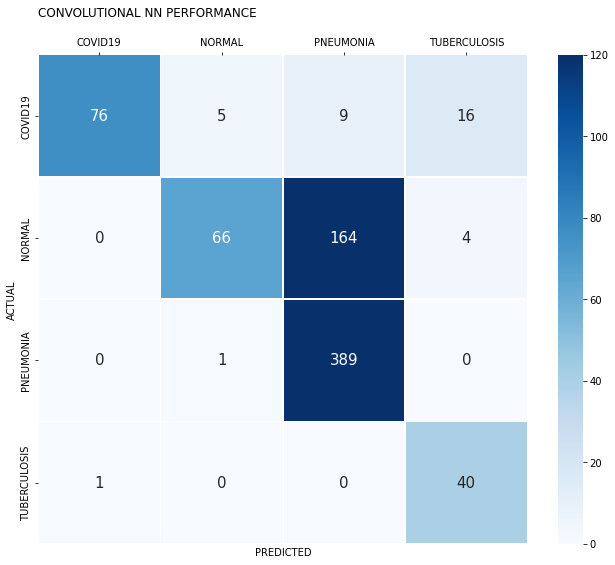

In [31]:
cnn_df = get_confusion_df(model, test_ds)
plot_heamtmap(cnn_df, 'Convolutional NN')

We see that most of the categories are properly identified, but a disproportionate amount of (actually) normal images were classified as pneumonia. In the future, we should aim to improve the ratio of correctly classified to incorrectly classified, and determine why normal scans would be mistaken as pneumonia.